#### Imports are Necessary

In [1]:
import torch
from torch.utils.data import DataLoader

import numpy as np

from rpn.build_rpn import RPN_Model
from sam.build_sam import SAM_Model
from transformers import pipeline

from data_builder.build_dataset import PlanetscopeDataset

import os
import time
import json

from eval_utils import filter_boxes_predictions, filter_boxes, calculate_iou, calculate_precision_recall, filter_masks
from eval_utils import generate_random_bounding_boxes, generate_uniform_spaced_bounding_boxes

import pandas as pd
from rpn import _transforms as T
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches

/home/aghosh57/.conda/envs/dl4cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_transform(image_enhancement="FALSE"):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    if image_enhancement == "TRUE":
        transforms.append(T.ContrastBasedAdaptiveGammaCorrection())
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

#### Usual Definition

In [3]:
#Create a folder with unix timestamp
root_path = os.getcwd() + '/results/' + str(int(time.time())) + '/'
os.mkdir(root_path)

with open('gen_masks_config.json', 'r') as f:
    eval_config = json.load(f)

print("Mask Gen Configuration")
print(json.dumps(eval_config, indent=1))

Mask Gen Configuration
{
 "DATASET_PATH": "/scratch/aghosh57/SAT-SAM(Dataset)/ps_rwanda/all_dataset/",
 "REGION": "RWANDA",
 "MODEL": "ALL",
 "IMAGE_ENHANCEMENT": "FALSE",
 "FILTRATION": "FALSE",
 "TRAIN_TYPE": "FINETUNE",
 "NMS_THRESHOLD": 0.9,
 "PRED_CONFIDENCE_THRESHOLD": 0.6,
 "ENSEMBLE_BOX_OVERLAP_THRESHOLD": 0.5,
 "ENSEMBLE_BOX_BETA": 0.3,
 "RPN_MODEL_PATH": "rpn/checkpoints/1692043128/rpn_model_1.09.pth",
 "SAM_MODEL_PATH": "sam/checkpoint/sam_vit_l_0b3195.pth"
}


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset_test = PlanetscopeDataset(eval_config['DATASET_PATH'], get_transform(image_enhancement=eval_config['IMAGE_ENHANCEMENT']))
# dataset2_test = PlanetscopeDataset(eval_config['DATASET2_PATH'], get_transform(image_enhancement=eval_config['IMAGE_ENHANCEMENT']))

# dataset_test = ConcatDataset([dataset1_test, dataset2_test])

torch.manual_seed(1)
indices = torch.randperm(len(dataset_test)).tolist()
dataset_test = torch.utils.data.Subset(dataset_test, indices[-int(len(indices)*0.2):])

In [5]:

rpn_model = RPN_Model(eval_config['RPN_MODEL_PATH'], 2, device, eval_config['TRAIN_TYPE'])
sam_model = SAM_Model(eval_config['SAM_MODEL_PATH'], 'large', device)

vanilla_sam_model = pipeline("mask-generation", model="facebook/sam-vit-large", device=device)

maskrcnn_model = RPN_Model(eval_config['RPN_MODEL_PATH'], 2, device, eval_config['TRAIN_TYPE']) #Load the Pre-Trained MaskRCNN model

In [6]:
def collate_masks(masks):
    cumulative_mask = np.zeros(tuple(masks.shape[1:3]), dtype=np.uint8)
    print(cumulative_mask.shape)
    delta_pred_mask = 255 // len(masks)

    for i, mask in enumerate(masks):
        cumulative_mask[mask > 0] = (i + 1)*delta_pred_mask

    return cumulative_mask

Image:  0
SAT-SAM:  (18, 448, 448)
SAM:  (101, 448, 448)
MASKRCNN:  (18, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


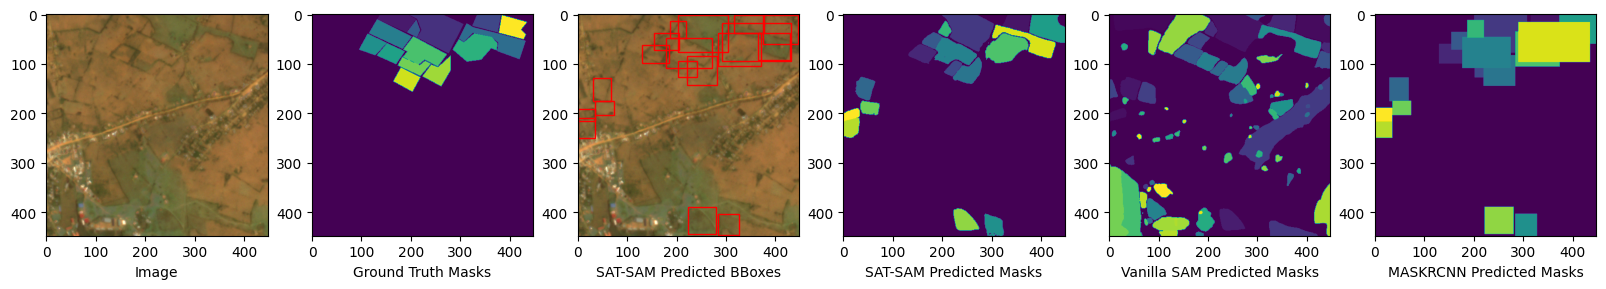

Image:  1
SAT-SAM:  (18, 448, 448)
SAM:  (71, 448, 448)
MASKRCNN:  (18, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


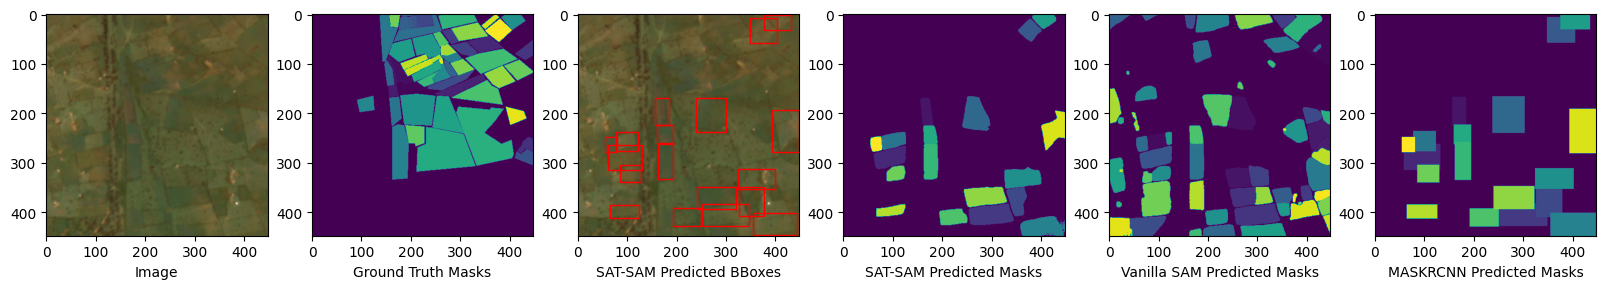

Image:  2
SAT-SAM:  (16, 448, 448)
SAM:  (45, 448, 448)
MASKRCNN:  (16, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


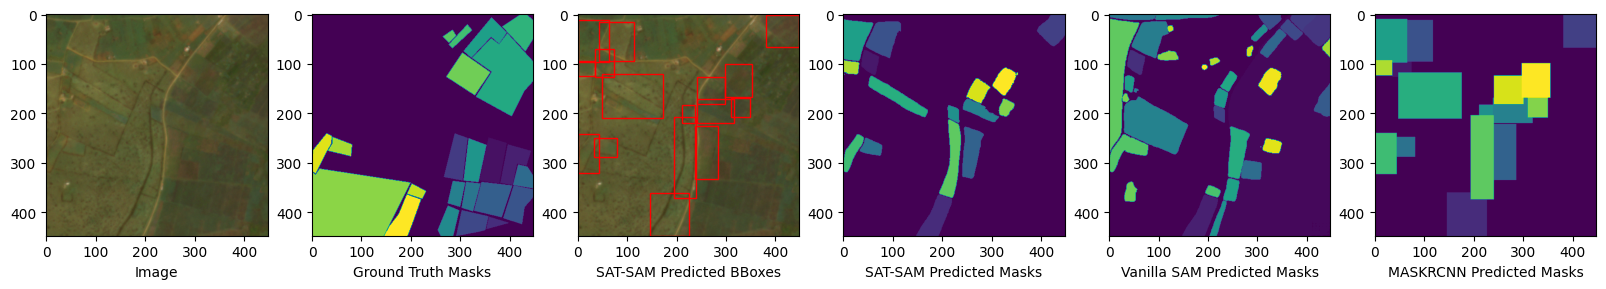

Image:  3
SAT-SAM:  (12, 448, 448)
Error in image:  3 18
Image:  4
SAT-SAM:  (13, 448, 448)
SAM:  (33, 448, 448)
MASKRCNN:  (13, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


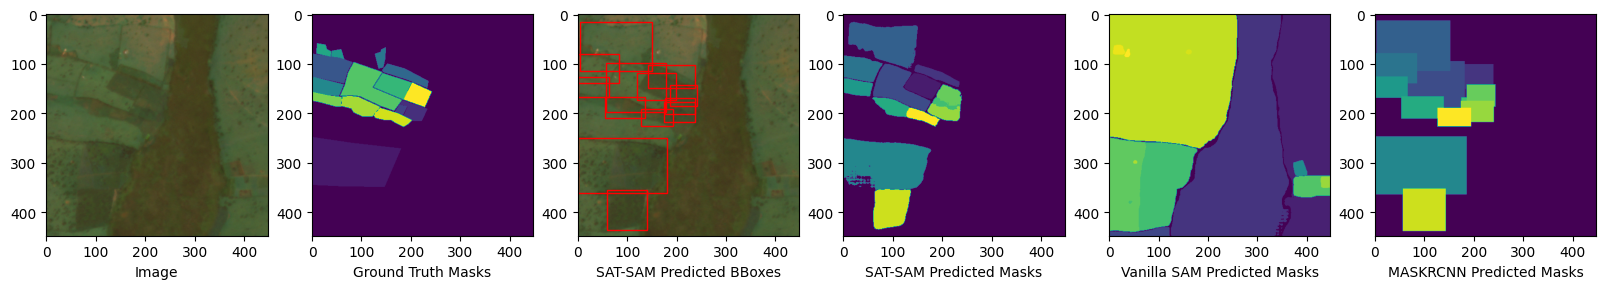

Image:  5
SAT-SAM:  (3, 448, 448)
SAM:  (28, 448, 448)
MASKRCNN:  (3, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


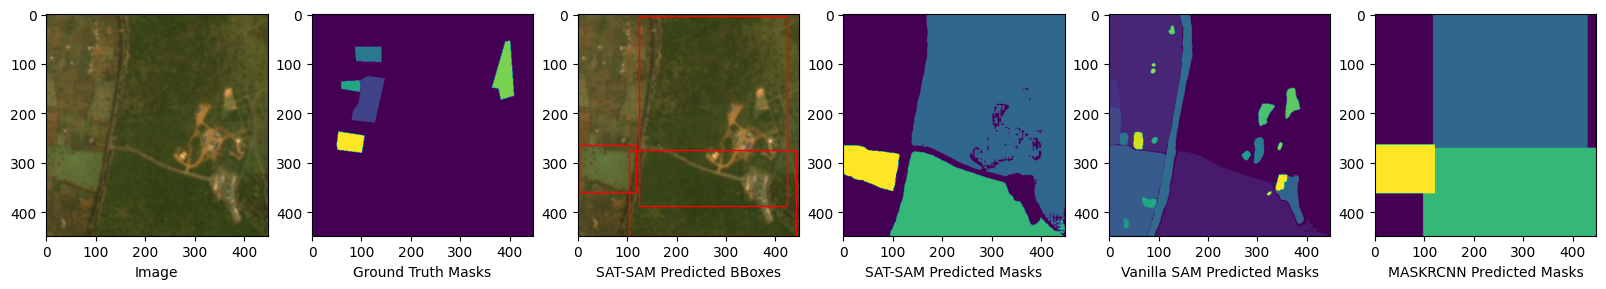

Image:  6
SAT-SAM:  (17, 448, 448)
SAM:  (40, 448, 448)
MASKRCNN:  (17, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


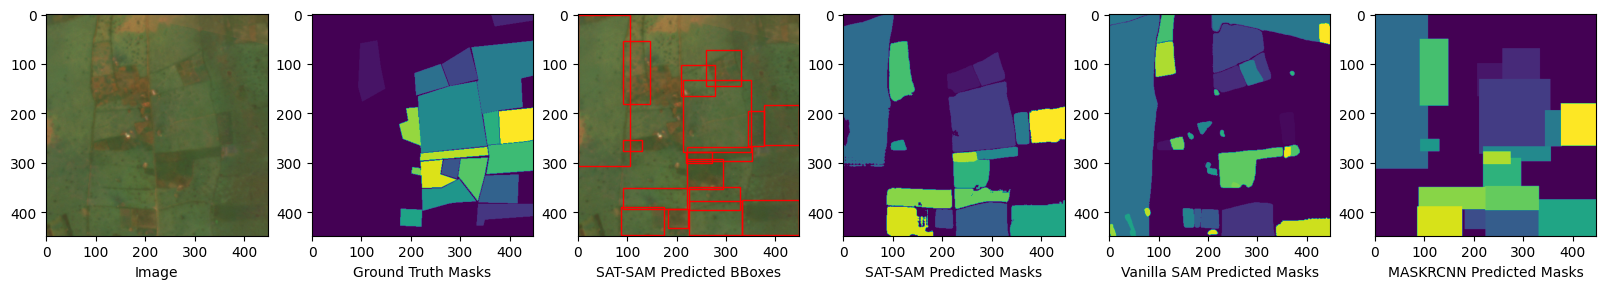

Image:  7
SAT-SAM:  (3, 448, 448)
SAM:  (53, 448, 448)
MASKRCNN:  (3, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


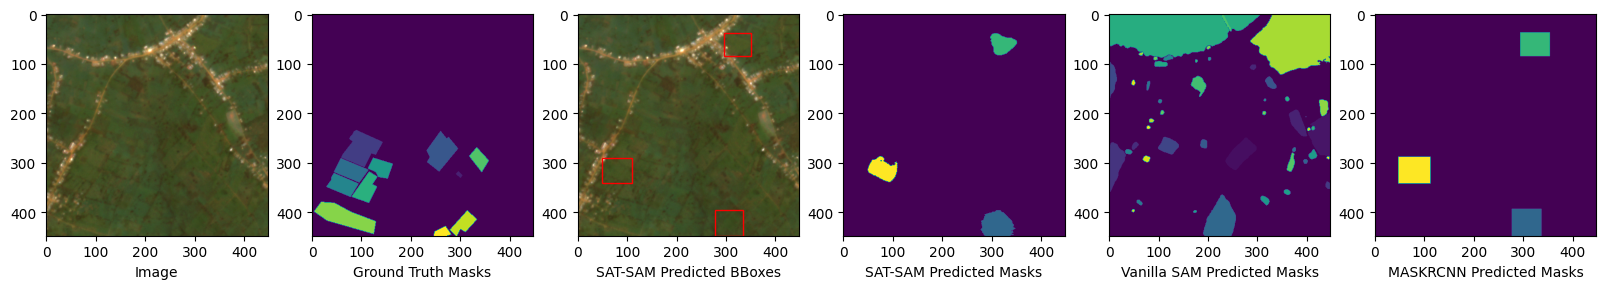

Image:  8
SAT-SAM:  (17, 448, 448)
SAM:  (61, 448, 448)
MASKRCNN:  (17, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


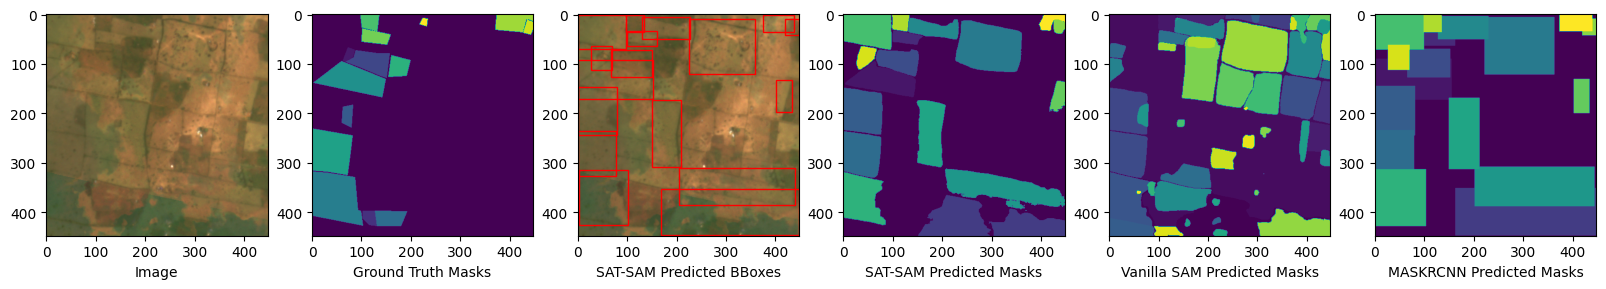

Image:  9
SAT-SAM:  (13, 448, 448)
SAM:  (26, 448, 448)
MASKRCNN:  (13, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


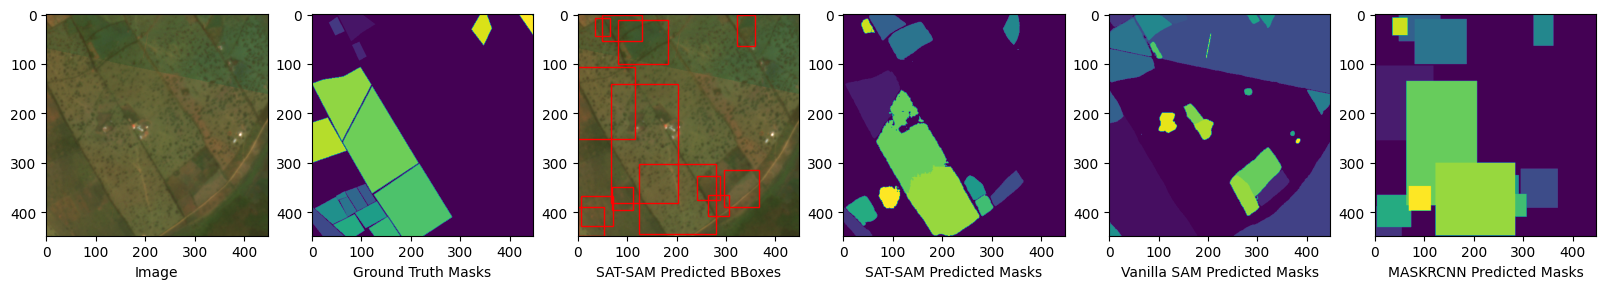

Image:  10
SAT-SAM:  (25, 448, 448)
SAM:  (64, 448, 448)
MASKRCNN:  (25, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


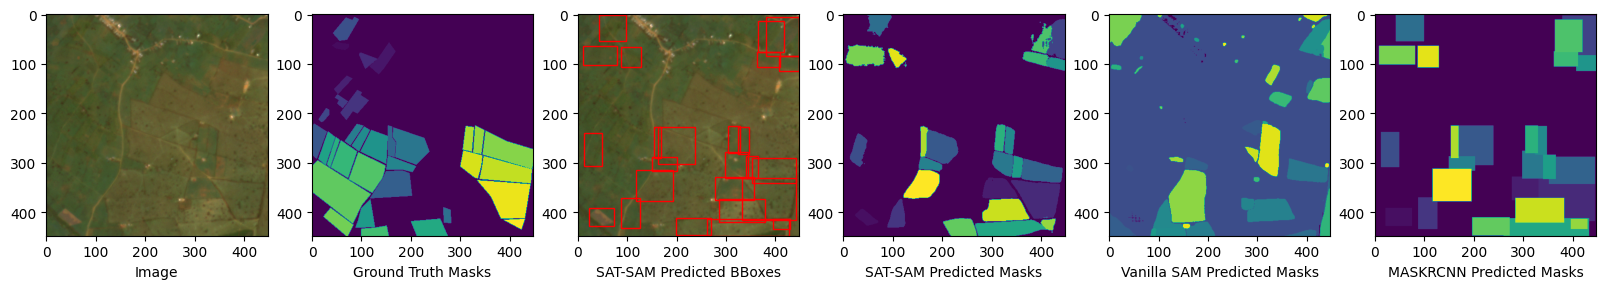

Image:  11
SAT-SAM:  (18, 448, 448)
SAM:  (65, 448, 448)
MASKRCNN:  (18, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


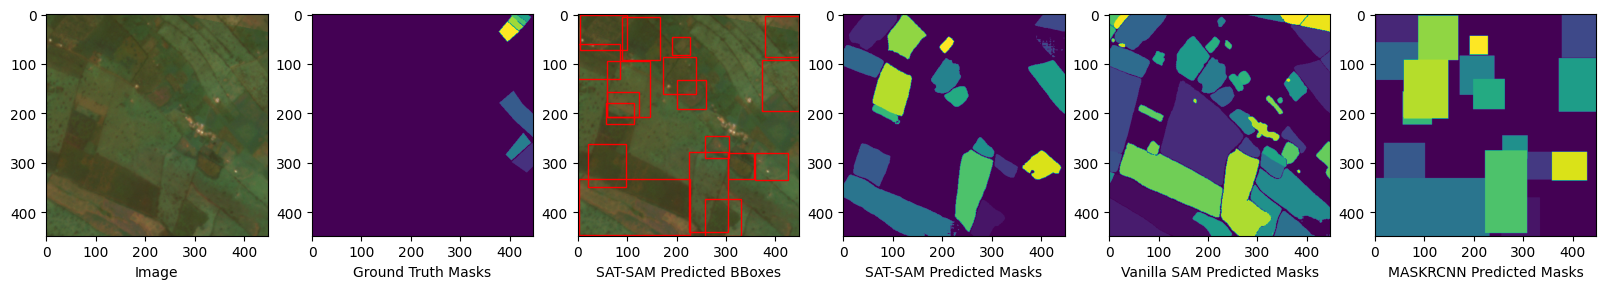

Image:  12
SAT-SAM:  (8, 448, 448)
Error in image:  12 93
Image:  13
SAT-SAM:  (19, 448, 448)
SAM:  (40, 448, 448)
MASKRCNN:  (19, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


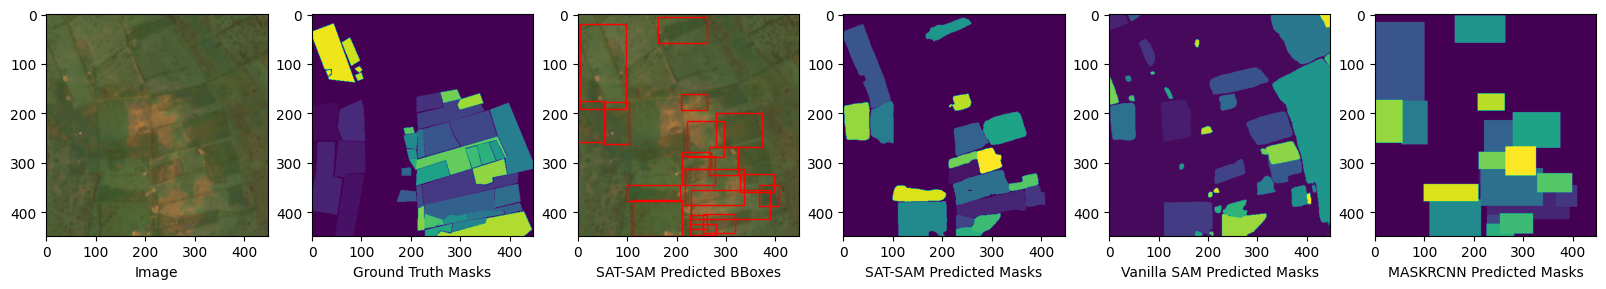

Image:  14
SAT-SAM:  (5, 448, 448)
SAM:  (34, 448, 448)
MASKRCNN:  (5, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


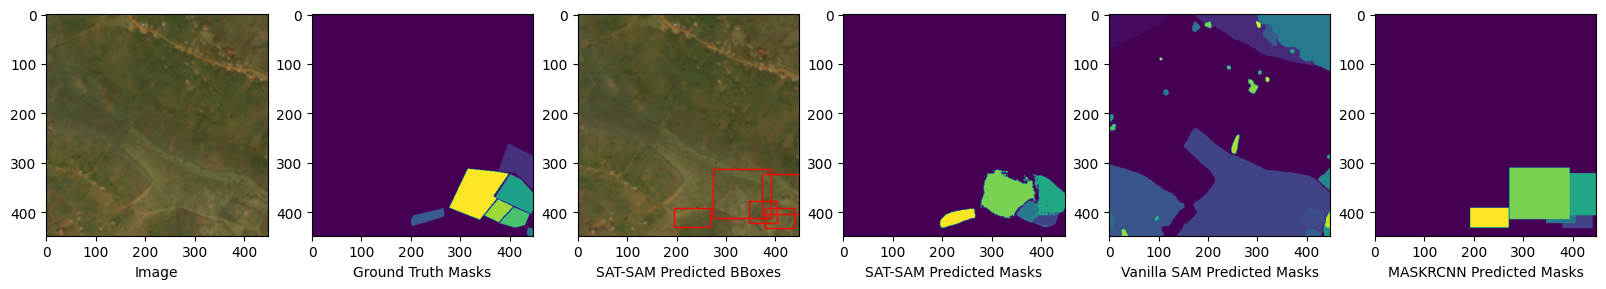

Image:  15
SAT-SAM:  (5, 448, 448)
SAM:  (25, 448, 448)
MASKRCNN:  (5, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


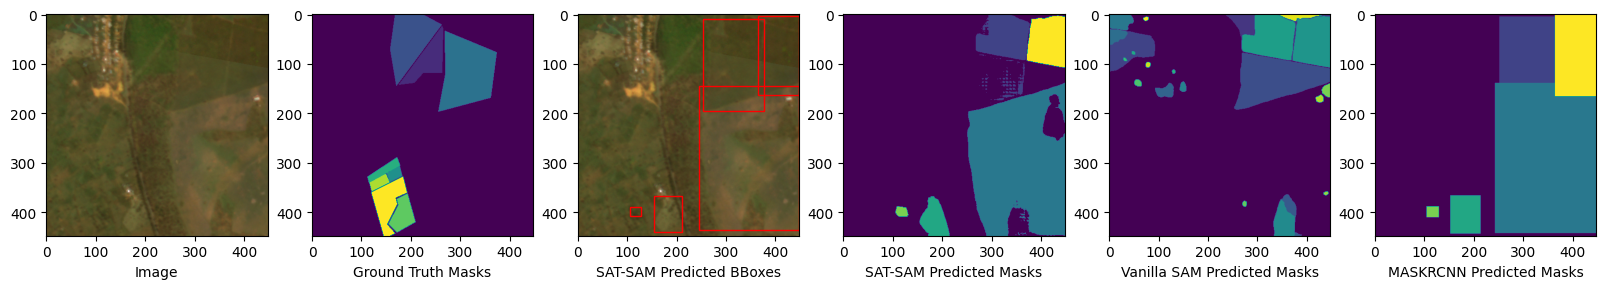

Image:  16
SAT-SAM:  (2, 448, 448)
SAM:  (66, 448, 448)
MASKRCNN:  (2, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


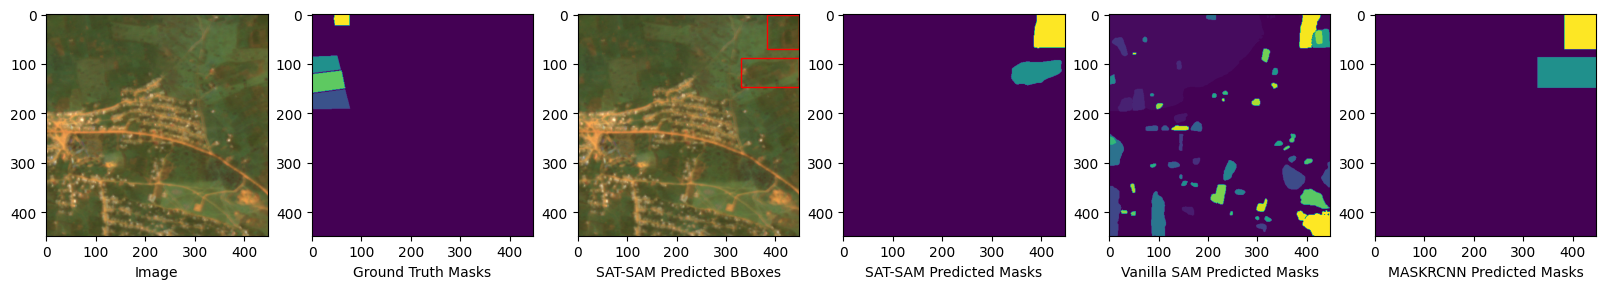

Image:  17
SAT-SAM:  (7, 448, 448)
SAM:  (43, 448, 448)
MASKRCNN:  (7, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


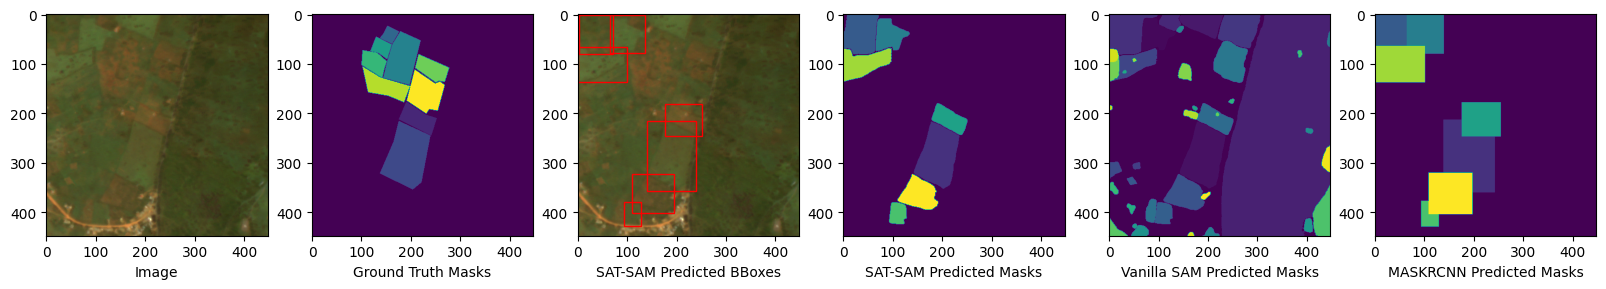

Image:  18
SAT-SAM:  (12, 448, 448)
SAM:  (54, 448, 448)
MASKRCNN:  (12, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


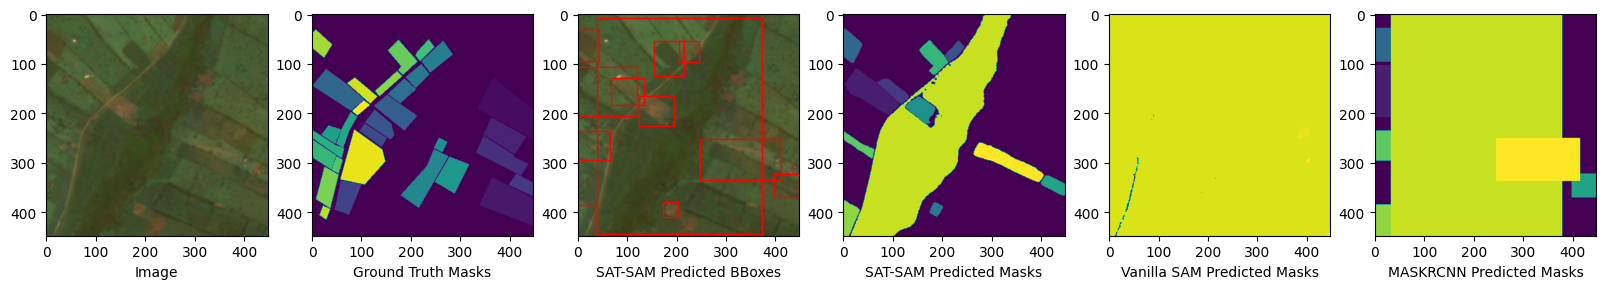

Image:  19
SAT-SAM:  (7, 448, 448)
SAM:  (32, 448, 448)
MASKRCNN:  (7, 448, 448)
(448, 448)
(448, 448)
(448, 448)
(448, 448)


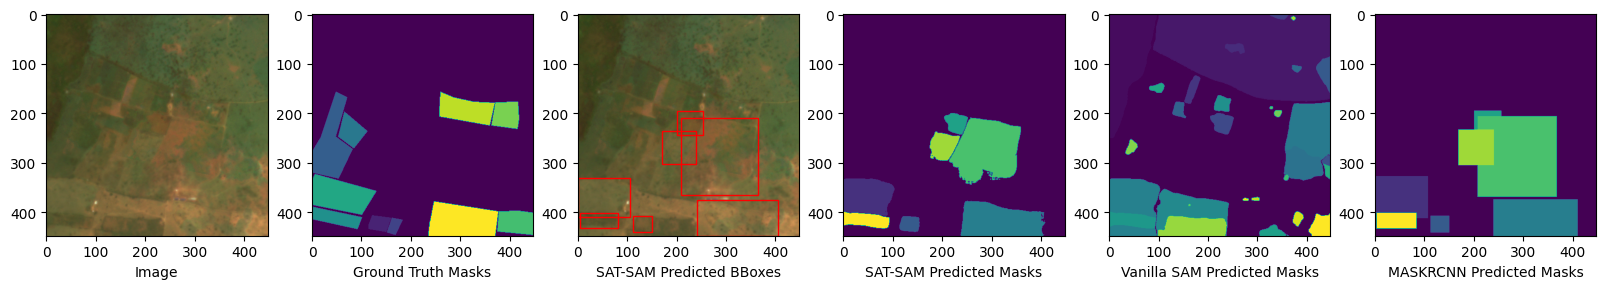

In [10]:
for i, (id, sam_image, rpn_image, target, ensemble, path)  in enumerate(dataset_test): 
    try:
        print('Image: ', i)
        rpn_image = rpn_image.squeeze(0).to(device)

        predictions = rpn_model.predict(rpn_image)
        predictions = rpn_model.postprocess(predictions, nms_threshold=eval_config['NMS_THRESHOLD'], score_threshold=eval_config['PRED_CONFIDENCE_THRESHOLD'])

        if predictions['boxes'].shape[0] == 0:
            print("No boxes detected, generating random boxes")
            bboxes = generate_uniform_spaced_bounding_boxes(sam_image.size[0], sam_image.size[1], int(sam_image.size[0]*0.25))
            if eval_config['FILTRATION'] == 'TRUE':
                filtered_boxes = filter_boxes(bboxes, ensemble, eval_config['ENSEMBLE_BOX_OVERLAP_THRESHOLD'])
                low_res_masks, iou_predictions = sam_model.predict(sam_image, filtered_boxes)
                sat_sam_pred_boxes = filtered_boxes
            else:
                low_res_masks, iou_predictions = sam_model.predict(sam_image, bboxes)
                sat_sam_pred_boxes = bboxes
        else:
            if eval_config['FILTRATION'] == 'TRUE':
                filtered_predictions = filter_boxes_predictions(predictions, ensemble, eval_config['ENSEMBLE_BOX_BETA'], eval_config['ENSEMBLE_BOX_OVERLAP_THRESHOLD'])
                low_res_masks, iou_predictions = sam_model.predict(sam_image, filtered_predictions)
                sat_sam_pred_boxes = filtered_predictions
            else:
                low_res_masks, iou_predictions = sam_model.predict(sam_image, predictions['boxes'])
                sat_sam_pred_boxes = predictions['boxes']

        high_res_masks = sam_model.postprocess(low_res_masks, tuple(sam_image.size))
        pred_masks_sat_sam = high_res_masks.squeeze().cpu().numpy()
        print('SAT-SAM: ', pred_masks_sat_sam.shape)

        outputs = vanilla_sam_model(sam_image, points_per_batch=32)
        if eval_config['FILTRATION'] == 'TRUE':
            pred_masks_sam = filter_masks(outputs['masks'], ensemble, eval_config['ENSEMBLE_BOX_OVERLAP_THRESHOLD'])
        else:
            pred_masks_sam = outputs["masks"]
        pred_masks_sam = np.array(pred_masks_sam)
        print('SAM: ', pred_masks_sam.shape)

        predictions = maskrcnn_model.predict(rpn_image)
        predictions = maskrcnn_model.postprocess(predictions, nms_threshold=eval_config['NMS_THRESHOLD'], score_threshold=eval_config['PRED_CONFIDENCE_THRESHOLD'])
        if eval_config['FILTRATION'] == 'TRUE':
            pred_masks_maskrcnn = filter_masks(np.squeeze(np.array(predictions['masks'])), ensemble, eval_config['ENSEMBLE_BOX_OVERLAP_THRESHOLD'])
        else:
            pred_masks_maskrcnn = predictions['masks'].squeeze()
        pred_masks_maskrcnn = np.array(pred_masks_maskrcnn)
        print('MASKRCNN: ', pred_masks_maskrcnn.shape)

        # Plotting the results
        fig, ax = plt.subplots(1, 6, figsize=(20, 5))

        ax[0].imshow(sam_image)
        ax[0].set_xlabel('Image')

        ax[1].imshow(collate_masks(target['masks']))
        ax[1].set_xlabel('Ground Truth Masks')

        ax[2].imshow(sam_image)
        ax[2].set_xlabel('SAT-SAM Predicted BBoxes')

        for i in range (len(pred_masks_sat_sam)):
            xmin = sat_sam_pred_boxes[i][0]
            ymin = sat_sam_pred_boxes[i][1]
            xmax = sat_sam_pred_boxes[i][2]
            ymax = sat_sam_pred_boxes[i][3]
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
            ax[2].add_patch(rect)

        ax[3].imshow(collate_masks(pred_masks_sat_sam))
        ax[3].set_xlabel('SAT-SAM Predicted Masks')

        ax[4].imshow(collate_masks(pred_masks_sam))
        ax[4].set_xlabel('Vanilla SAM Predicted Masks')

        ax[5].imshow(collate_masks(pred_masks_maskrcnn))
        ax[5].set_xlabel('MASKRCNN Predicted Masks')

        plt.show()
    except:
        print("Error in image: ", i, id)
        continue